In [1]:
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = (x_train.astype(np.float32)-127.5)/127.5
print(x_train.shape)

(60000, 28, 28)


In [4]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
print(x_train.shape)

(60000, 784)


### Create Generator

In [5]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units= 512, input_dim= 100))
    generator.add(ReLU())
    
    generator.add(Dense(units= 512))
    generator.add(ReLU())
    
    generator.add(Dense(units= 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units= 784, activation="tanh"))
    
    generator.compile(loss= "binary_crossentropy",
                     optimizer= Adam(lr= 0.0001, beta_1= 0.5))
    
    return generator

In [6]:
g= create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

C:\Users\EBRU\anaconda3\envs\newenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Create Discriminator

In [7]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim= 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=256))
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units=1, activation= "sigmoid"))
    
    discriminator.compile(loss="binary_crossentropy",
                         optimizer= Adam(lr=0.0001, beta_1=0.5))
    return discriminator

In [8]:
d= create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

### Model

In [9]:
def create_gan(discriminator, generator):
    discriminator.trainable= False
    gan_input= Input(shape=100,)
    x= generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs= gan_input, outputs= gan_output)
    gan.compile(loss= "binary_crossentropy", optimizer="adam")
    return gan

In [10]:
gan= create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1643280   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


### Train

In [11]:
epochs= 50
batch_size= 256

for e in range(epochs):
    for _ in range(batch_size):
        noise = np.random.normal(0,1,[batch_size,100])
        generated_images= g.predict(noise)
        image_batch= x_train[np.random.randint(low=0, high= x_train.shape[0], size= batch_size)]
        x= np.concatenate([image_batch, generated_images])
        
        # yukarıda x'i oluştururken ilk önce image_batch yani real görüntüler verildi
        # bu da ilk 256 görselin 1 olarak etiketleneceğini gösteriyor
        # burada etiketleme yapılmıştır.
        # kalan son 256 görsel ise 0 olarak kalıcaktır.
        y_dis = np.zeros(batch_size*2)
        y_dis[:batch_size]=1
        
        # discriminator'de artık eğitim başlıyor
        d.trainable= True
        d.train_on_batch(x,y_dis)
        
        # generator eğitimi de başlamalı çünkü artık modeli çalıştırıyoruz
        noise= np.random.normal(0,1,[batch_size,100])
        # üretilen görsellere etiketleri 1 olarak atıyoruz ki discriminator kandırılabilsin.
        y_gen= np.ones(batch_size)
        # discriminator eğitimini duraklatıyoruz ve generator eğitimini tamamlıyoruz
        d.trainable= False
        
        gan.train_on_batch(noise, y_gen)
    print("epochs: ", e)        

8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  0
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  1
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  2
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  3
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  4


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 8ms/step
epochs:  5
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 8ms/step
epochs:  6
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  7
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  8
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  9


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  10
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  11
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  12
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  13
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  14


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  15
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 2ms/step
epochs:  16
8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  17
8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  18
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  19


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  20
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  21
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  22
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  23
8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  24


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  25
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  26
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  27
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  28
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  29


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  30
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  31
8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  32
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  33
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  34


8/8 [==============================] - 0s 2ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  35
8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  36
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  37
8/8 [==============================] - 0s 8ms/step


8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 5ms/step
epochs:  38
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  39


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  40
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 1ms/step
epochs:  41
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  42
8/8 [==============================] - 0s 7ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  43
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  44


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 6ms/step
epochs:  45
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 7ms/step
epochs:  46
8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 8ms/step
epochs:  47
8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 6ms/step


8/8 [==============================] - 0s 4ms/step
epochs:  48
8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step
epochs:  49


In [12]:
g.save_weights("gans_model.h5")

4/4 [==============================] - 0s 3ms/step


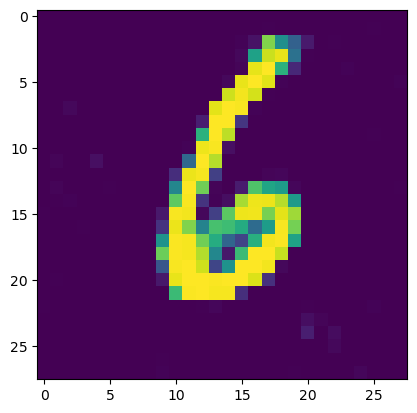

In [21]:
noise= np.random.normal(loc=0, scale=1, size=[100,100])
generated_images= g.predict(noise)
generated_images= generated_images.reshape(100, 28,28)
plt.imshow(generated_images[94], interpolation='nearest')
plt.show()